# Sportsbetting Project Bundesliga

This Notebook contains the development of a machine learning model to predict future Bundesliga games. The goal is to pass the algorithm two team names (i.e. Home Team and Away Team) to get the probability of the outcome of the game. The Idea is to create a vector for each Team, which includes selected features like goals scored, average possession etc. Those team-vectors will be applied to predict the outcome of future matches.

# Setup

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 50)
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras

#Plotting, Graphs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# fetching data from website 
import requests
import bs4
import lxml
from bs4 import BeautifulSoup

# Load and select Data
Mostly from **FBREF.com**, an incredible informative website. The website holds different tables with a variety of statistics, we will fetch the most important features step by step and attach them to a FeatureTable. Since I played soccer for my whole life, the importance of a feature will be evaluated by myself as of now, but later on we will use feature selection methods to see which features really impact the outcome, and which features maybe even worsen the accuracy of the model. To be able to choose the most relevant features, we have to make sure to create a broad dataset in the beginning to not miss out on potential features and an increase in accuracy. 

I downloaded the data from the mentioned website and saved those as a .csv file. To automate this process we could use methods like "TheBeautifulSoup", which fetches the most recent stats on the fly. However, Since the website is complex and saving the data as .csv simplifies the data preprocessing, I spend the extra minutes each week to update the most recent stats.

In [2]:
# First, The League Table
LeagueTable = pd.read_csv('LeagueTable.csv')
LeagueTable.head()

,Rk,Squad,MP,W,D,L,GF,GA,GDiff,Pts,xG,xGA,xGDiff,xGDiff/90,Last 5,Attendance
0,1,Bayern Munich,18,13,3,2,53,25,28,42,39.0,23.6,15.4,0.86,W L W W W,NaN
1,2,RB Leipzig,18,10,5,3,31,17,14,35,32.7,16.8,15.9,0.88,W L D W L,2000.0
2,3,Leverkusen,18,9,5,4,32,18,14,32,23.5,18.5,5.1,0.28,L D L W L,671.0
3,4,Wolfsburg,18,8,8,2,27,19,8,32,26.5,22.9,3.7,0.20,L D D W W,1144.0
4,5,M'Gladbach,18,8,7,3,35,28,7,31,31.1,23.9,7.2,0.40,W W D W W,1068.0


In [3]:
# Selecting the most important Features and adding them to the FeatureTable
FeatureTable = LeagueTable[['Squad', 'GF', 'GA', 'xG', 'xGA', 'Last 5']]
FeatureTable = FeatureTable.rename(columns={'Squad': 'Team', 'Last 5': 'Form'})
FeatureTable = FeatureTable.sort_values('Team', ignore_index=True)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form
0,Arminia,14,29,12.8,29.4,L W D W L
1,Augsburg,19,27,17.4,29.4,W L L L W
2,Bayern Munich,53,25,39.0,23.6,W L W W W
3,Dortmund,35,26,37.6,20.6,W W D L L
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W


In [4]:
# Second, the Shooting Stats
ShootingStats = pd.read_csv('ShootingStats.csv')
#ShootingStats.head()

In [5]:
# Again, adding the most important Features to be Featuretable
ShootingStats = ShootingStats[['SoT', 'SoT%', 'G/SoT', 'Dist']]
frames = [FeatureTable, ShootingStats] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0


In [6]:
#Third, the Passing Stats
PassingStats = pd.read_csv('PassingStats.csv')
#PassingStats.head()

In [7]:
# Again, adding the most important Features to be Featuretable
PassingStats = PassingStats[['KP', 'Cmp%', '3-Jan', 'PPA', 'CrsPA', 'Prog']]
PassingStats = PassingStats.rename(columns={'3-Jan': 'P_FT'})
frames = [FeatureTable, PassingStats] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709


In [8]:
#Adding another passing statistic
PassingStats2 = pd.read_csv('PassingStats2.csv')
#PassingStats2.head()

In [9]:
# Again, adding the most important Features to be Featuretable
PassingStats2 = PassingStats2[['TB', 'Sw', 'Crs']]
frames = [FeatureTable, PassingStats2] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249


In [10]:
#Adding goal creation statistics
GoalCreation = pd.read_csv('GoalCreation.csv')
#GoalCreation.head()

In [11]:
# Again, adding the most important Features to be Featuretable
GoalCreation = GoalCreation[['GCA', 'PassLive', 'PassDead', 'Drib']]
frames = [FeatureTable, GoalCreation] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206,57,42,3,4
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4


In [12]:
# Adding Defensive stats
DefensiveStats = pd.read_csv('DefensiveStats.csv')
#DefensiveStats.head()

In [13]:
# Again, adding the most important Features to be Featuretable
DefensiveStats = DefensiveStats[['%', 'Att 3rd']]
DefensiveStats = DefensiveStats.rename(columns={'%': 'SP%'})
frames = [FeatureTable, DefensiveStats] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,34.4,813
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206,57,42,3,4,36.6,646
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,32.8,712


In [14]:
#Adding goal creation statistics
PossessionStats = pd.read_csv('PossessionStats.csv')
#PossessionStats.head()

In [15]:
# Again, adding the most important Features to be Featuretable
PossessionStats = PossessionStats[['Poss', '3-Jan', 'CPA', 'Rec%', 'MV']]
PossessionStats = PossessionStats.rename(columns={'3-Jan': 'C_FT'})
frames = [FeatureTable, PossessionStats] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,C_FT,CPA,Rec%,MV
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531,44.3,158,39,82.1,45.15
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486,43.1,174,40,79.2,104.28
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,34.4,813,62.7,316,111,86.7,891.40
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206,57,42,3,4,36.6,646,62.2,336,107,88.7,615.20
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,32.8,712,52.5,212,86,80.7,186.20


### Abbreviation Definition

- **GF** = Goals for  $\qquad\qquad\qquad\;\;\;$  **Prog** = Completed Pass in PA
- **GA** = Goals against           $\qquad\qquad\;\;\;\;\;$  **TB** = Trough Ball            
- **xG** = Expected Goals  $\qquad\quad\quad\;\;\;$  **GCA** = Goal creating Actions 
- **xGA** = Expected Goals against     $\qquad$  **PassLive** = Passes leading to a goal          
- **Form** = Current Form   $\qquad\quad\;\;\;\;\;$  **PassDead** = Dead Passes leading to a Goal  
- **SoT** = Shots on Target   $\qquad\quad\;\;\;\;\;$  **Drib** Dribblings leading to a Goal 
- **SoT%** = SoT / Shots   $\qquad\quad\;\;\;\;\;$ **SP** Successfull Pressure percentage
- **G/SoT** = Goals per SoT   $\qquad\quad\;\;\;\;\;$ **C_FT** Carries into final Third 
- **Dist** = Avg goal distance   $\qquad\quad\;\;\;\;\;$ **Att 3rd** Tackles in Attacking 3rd
- **KP** = Key Passes   $\qquad\quad\qquad\;\;\;\;\;$ **Poss** Possession (% of Passes attempted)
- **Cmp%** = Pass completion %   $\qquad\quad\;\;\;\;\;$ **C_FT** Carries into final Third   
- **P_FT** = Passes into final Third   $\qquad\quad\;\;$  **CPA** Carries into Penalty Area
- **PPA** = Passes Penalty Area (PA)   $\qquad$  **Rec%** Passes received percentage
- **CrsPA** = Crosses into PA   $\qquad\quad\;\;\;\;\;$  **MV** Market Value
- **Crs** = Crosses   $\qquad\quad\qquad\;\;\;\;\;$  **Sw** = Switches (over 40 yards)

# Feature Engineering
Now that the Feature Table is complete, we need to take care of formalities, like the categorical values of "Form". This Feature represents the current form of the team. A good way to represent this column in a single numerical value, is to add 1 for a Win and subtract 1 for a Loss (a Draw will be disregarded and counts as 0). So the current form will be in the range of -5 to 5.

In [16]:
type(FeatureTable['Form'])

pandas.core.series.Series

In [17]:
FormTeam = FeatureTable['Form']
for team in range(len(FeatureTable.Form)):
    wins = FormTeam.iloc[team].count('W') 
    losses = FormTeam.iloc[team].count('L')
    Form = FormTeam.iloc[team] = wins - losses
Form

1

So, the updated FeatureTable looks as follows

In [18]:
FeatureTable[0:18]

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,C_FT,CPA,Rec%,MV
0,Arminia,14,29,12.8,29.4,0,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531,44.3,158,39,82.1,45.15
1,Augsburg,19,27,17.4,29.4,-1,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486,43.1,174,40,79.2,104.28
2,Bayern Munich,53,25,39.0,23.6,3,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,34.4,813,62.7,316,111,86.7,891.40
3,Dortmund,35,26,37.6,20.6,0,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206,57,42,3,4,36.6,646,62.2,336,107,88.7,615.20
4,Eint Frankfurt,35,27,30.9,24.9,4,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,32.8,712,52.5,212,86,80.7,186.20
5,Freiburg,33,29,28.3,27.9,2,86,38.7,0.33,16.2,167,76.0,416,131,45,558,6,269,228,49,31,5,2,26.3,632,44.8,187,63,82.4,111.70
6,Hertha BSC,24,32,23.0,25.1,-2,77,35.5,0.27,17.4,153,79.7,476,131,43,599,10,357,241,35,28,1,0,29.7,617,52.8,238,81,83.7,251.93
7,Hoffenheim,28,30,29.2,31.8,0,85,39.2,0.27,16.9,157,79.7,534,149,45,676,13,291,208,49,29,2,5,33.8,606,50.2,227,72,84.0,238.33
8,Koln,15,31,18.1,31.2,-2,50,30.7,0.26,16.2,117,75.0,380,97,37,469,8,234,203,23,12,2,1,29.6,533,42.3,141,30,80.9,101.81
9,Leverkusen,32,18,23.5,18.5,-2,91,38.2,0.32,18.3,184,83.1,649,150,42,697,17,312,226,53,33,7,4,35.7,636,61.4,289,75,87.1,343.45


# First Investigations
Now that the FeatureTable is complete (as of now), it makes sense to take a look about the general performances of the teams and which features seem to have the most significant impact on the outcome of the game. 

## Homeadvantage
First, it is interesting to see if the "Homeadvantage" takes place in this season. To investigate this, we will use a Dataset from "Football-data.co.uk", which contains the whole matchplan including the outcome and some other statistics, like shots or shots on target.

In [19]:
MatchFeatures = pd.read_csv('D1.csv')
#Making sure the teamnames match to other dataset
MatchFeatures = MatchFeatures.replace('Bielefeld', 'Arminia')
MatchFeatures = MatchFeatures.replace('FC Koln', 'Koln')
MatchFeatures = MatchFeatures.replace('Ein Frankfurt', 'Eint Frankfurt')
MatchFeatures = MatchFeatures.replace('Hertha', 'Hertha BSC')
MatchFeatures = MatchFeatures.replace('Mainz', 'Mainz 05')
MatchFeatures = MatchFeatures.replace('M\'gladbach', 'M\'Gladbach')
MatchFeatures.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,...,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,D1,18/09/2020,19:30,Bayern Munich,Schalke 04,8,0,H,3,0,H,22,5,12,1,11,12,9,2,1,2,0,0,1.10,11.0,...,11.00,22.00,1.15,13.25,25.00,1.11,10.83,19.76,1.22,4.33,1.23,4.37,1.23,4.75,1.21,4.34,-2.50,1.89,2.04,1.87,2.02,1.95,2.18,1.85,2.02
1,D1,19/09/2020,14:30,Eint Frankfurt,Arminia,1,1,D,0,0,D,18,14,6,4,14,13,14,3,2,2,0,0,1.61,4.2,...,4.00,4.20,1.80,4.20,4.75,1.74,4.04,4.44,1.61,2.30,1.64,2.39,1.69,2.47,1.61,2.33,-0.75,1.96,1.97,1.96,1.96,2.02,1.98,1.94,1.93
2,D1,19/09/2020,14:30,Koln,Hoffenheim,2,3,A,1,2,A,13,13,6,7,12,13,1,6,0,0,0,0,2.60,3.5,...,3.75,2.63,2.70,3.85,2.83,2.59,3.51,2.67,1.61,2.30,1.65,2.35,1.72,2.40,1.64,2.27,0.00,1.91,2.02,1.92,2.01,1.97,2.08,1.89,1.98
3,D1,19/09/2020,14:30,Stuttgart,Freiburg,2,3,A,0,2,A,22,7,7,6,12,16,7,2,2,2,0,0,2.25,3.5,...,3.80,3.25,2.24,3.89,3.38,2.15,3.70,3.22,1.57,2.37,1.62,2.43,1.71,2.56,1.61,2.33,-0.25,1.92,2.01,1.91,2.02,1.94,2.04,1.88,1.99
4,D1,19/09/2020,14:30,Union Berlin,Augsburg,1,3,A,0,1,A,13,9,3,5,9,9,8,1,2,0,0,0,2.30,3.3,...,3.30,3.13,2.45,3.36,3.38,2.34,3.24,3.22,2.20,1.66,2.22,1.73,2.27,1.83,2.15,1.71,-0.25,2.02,1.91,2.00,1.92,2.05,1.93,2.00,1.87


In [20]:
MatchPlan = MatchFeatures[['HomeTeam', 'AwayTeam', 'FTR']] #FTR = Full-Time-Result
MatchPlan.tail()

,HomeTeam,AwayTeam,FTR
166,Union Berlin,M'Gladbach,D
167,Werder Bremen,Schalke 04,D
168,RB Leipzig,Leverkusen,H
169,Koln,Arminia,H
170,Wolfsburg,Freiburg,H


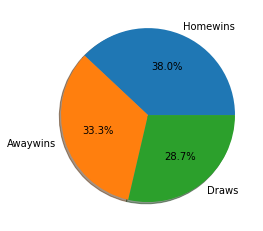

In [21]:
wins_home = len(MatchPlan[MatchPlan['FTR'] == 'H'])
home_perc = wins_home/len(MatchPlan)*100
wins_away = len(MatchPlan[MatchPlan['FTR'] == 'A'])
away_perc = wins_away/len(MatchPlan)*100
draws = len(MatchPlan[MatchPlan['FTR'] == 'D'])
draw_perc = draws/len(MatchPlan)*100
ratio = [home_perc, away_perc, draw_perc]

labels = 'Homewins', 'Awaywins', 'Draws'
fig1, ax1 = plt.subplots()
ax1.pie(ratio, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

All in all, there does not seem to be a home advantage this season. Still, experiences show that homeadvantages usually take place; this season maybe not so much because of the Pandemic. There could be still a performance difference when looking at the individual teams, so that's where we will have another look at.

In [22]:
# Calculating number of home wins, away wins and draws
wins = pd.DataFrame(columns=('Team', 'HW', 'AW', 'D'))

TeamHome = MatchPlan.groupby('HomeTeam')
TeamAway = MatchPlan.groupby('AwayTeam')
wins.Team = FeatureTable['Team']

# Home wins and draws as home team
for team in range(len(wins.Team)):
    wins.HW[team] = TeamHome.FTR.sum().values[team]
    wins.D[team] = TeamHome.FTR.sum().values[team]
    wins.HW[team] = wins.HW[team].count('H')
    wins.D[team] = wins.D[team].count('D')

#Away wins and draws as away team
for team in range(len(wins.Team)):
    wins.AW[team] = TeamAway.FTR.sum().values[team]
    dummy = TeamAway.FTR.sum().values[team]
    dummy = dummy.count('D')
    wins.AW[team] = wins.AW[team].count('A')
    wins.D[team] = wins.D[team] + dummy

wins.head()

,Team,HW,AW,D
0,Arminia,4,1,2
1,Augsburg,3,3,4
2,Bayern Munich,7,7,3
3,Dortmund,5,5,2
4,Eint Frankfurt,4,4,9


<Figure size 936x504 with 0 Axes>

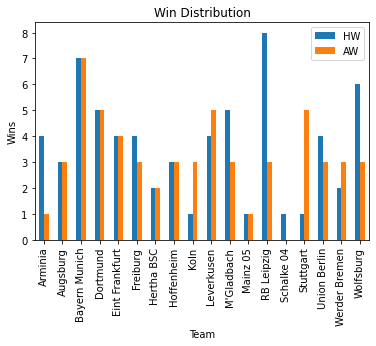

In [23]:
plt.figure(figsize=(13,7))
wins.plot.bar(x='Team', y=['HW', 'AW'])
plt.title('Win Distribution')
plt.ylabel('Wins')
plt.show()

In contrast to the overall similar Home and Away performance shown in the pie chart, the performances of the individual teams seem to differ in some cases, as shown above. With extrem cases like Arminia Bielefeld, Stuttgart or RB Leipzig, it might make sense to include some sort of distinction between home and away performances. However, as long as there can no clear Homeadvantage be observed, this idea might be postponed for the future.

## Feature Correlation

It also makes sense to see which of our features seem to have to biggest impact, and which of them we might be even able to drop. Having the wrong features can negatively impact the accuracy of the model later on. If we included all the features found on the website mentioned above (FBREF), we could easily get up to over 100 features. The main task is to find the most valueable features for the Training set. Since this is a very important step, we might keep including as many feature as possible and use different techiques to sort them out. 

**Note - as of now we have 29 Features. When using ALL features, the model (Logistic Regression) did not converge to a solution. This underlines the importance of Feature Selection**

First, let's have a look how some of the feature are correlated to each other.

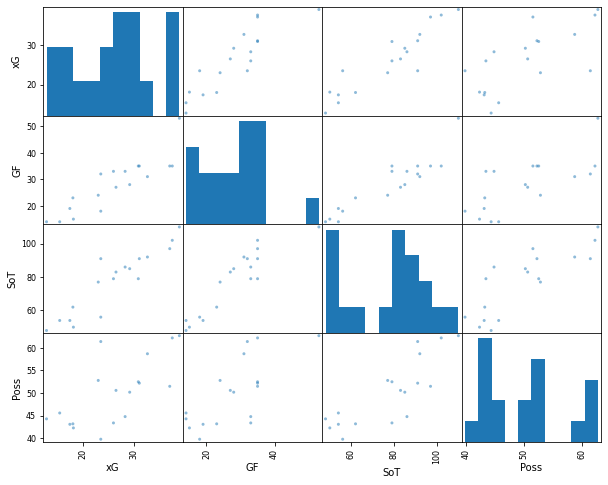

In [24]:
from pandas.plotting import scatter_matrix

features = ["xG", "GF", "SoT", "Poss"]
scatter_matrix(FeatureTable[features], figsize=(10, 8))
plt.show()

After using different features to investigate the correlation, a lot of times we could see a positive linear correlation between the chosen features (more shots on target = higher xG value, ..). Since we have only 18 teams, we have only the same amount of datapoints, which seems pretty less. However, a correlation between the features is visible. With this in mind, we could think about dropping some redundant features; for example, GF and xG seem to have such a strong correlation (which makes sense) that we could thinking about dropping the goals scored GF and only keep the expected goals xG. 

To have a better understanding of all the features and their correlation, we will create a heatmap

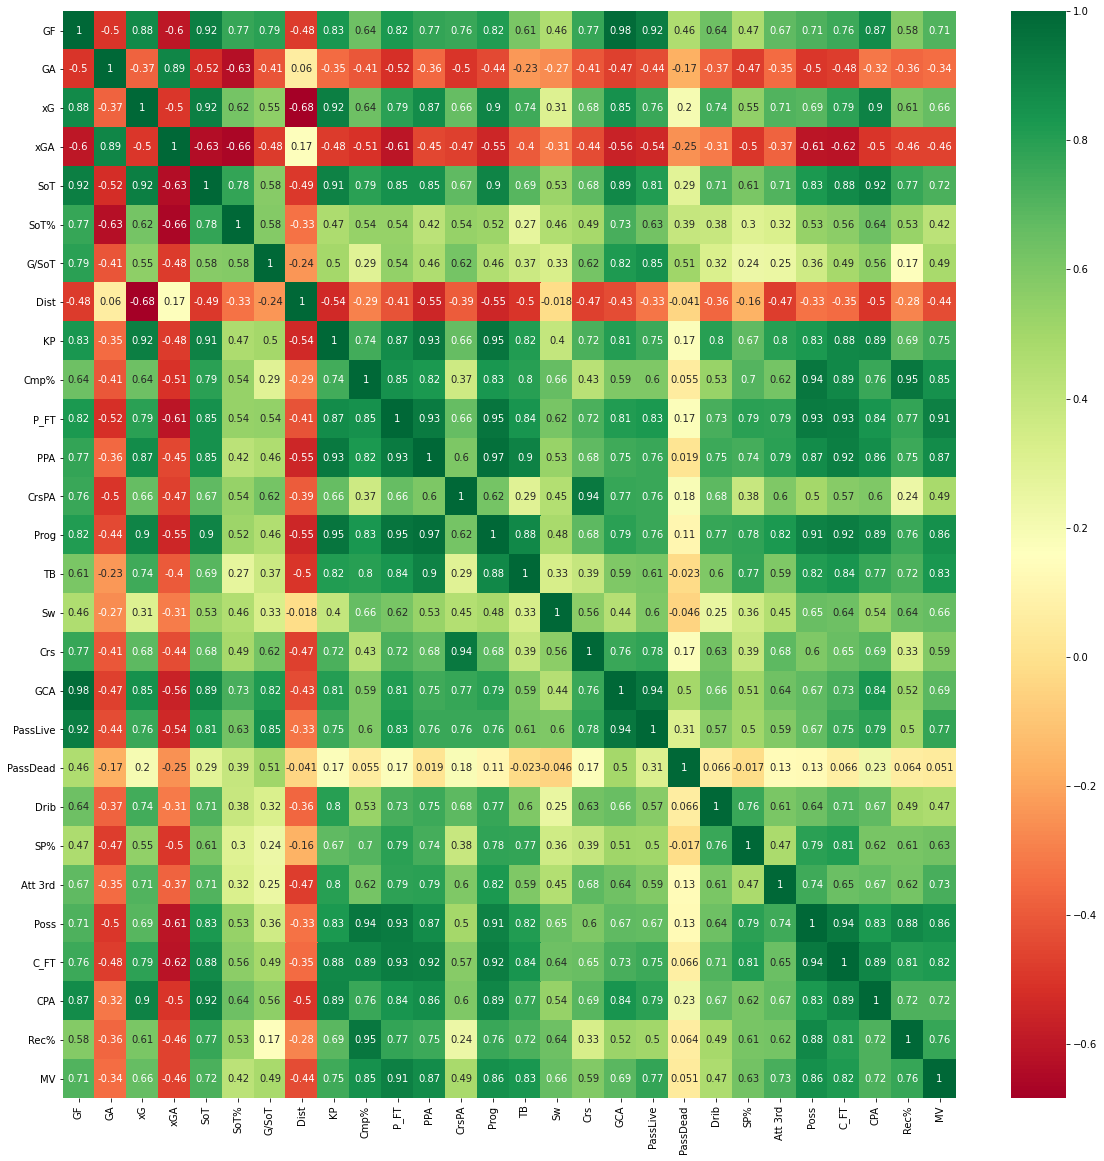

In [25]:
# get correlations of each feature in dataset
dataFeatures = FeatureTable.drop(['Team'], axis=1)
corrMat = dataFeatures.corr()
plt.figure(figsize=(20, 20))
# plot heat map
g = sns.heatmap(corrMat, annot=True, cmap='RdYlGn')

The Heatmap shows A LOT of correlations between the features. Green is the indicator for strong positive correlations. After looking at this data, we can reduce the features and probably can cut them in half. Having highly correlated features will reduce the accuracy of the model. First, we can start sorting out one of the features that's correlation is over **90%** to another feature. For convenience, the abbreviation definition is described below once again.

For example, Pass completion percentage (Cmp%) is highly correlated to Passes Received percentage (Rec%), so we can remove one of these attributes. To decide which ones to remove, we will have a look at the relation of all independend variables (features) to the outcome (full-time-result). The ones with a lower relationship to the outcome will be removed. First, we need to set up the completed FeatureTable including the matchdays and their outcomes, since we have not included the full time result (depentend variable) yet. 

### Abbreviation Definition

- **GF** = Goals for  $\qquad\qquad\qquad\;\;\;$  **Prog** = Completed Pass in PA
- **GA** = Goals against           $\qquad\qquad\;\;\;\;\;$  **TB** = Trough Ball            
- **xG** = Expected Goals  $\qquad\quad\quad\;\;\;$  **GCA** = Goal creating Actions 
- **xGA** = Expected Goals against     $\qquad$  **PassLive** = Passes leading to a goal          
- **Form** = Current Form   $\qquad\quad\;\;\;\;\;$  **PassDead** = Dead Passes leading to a Goal  
- **SoT** = Shots on Target   $\qquad\quad\;\;\;\;\;$  **Drib** Dribblings leading to a Goal 
- **SoT%** = SoT / Shots   $\qquad\quad\;\;\;\;\;$ **SP** Successfull Pressure percentage
- **G/SoT** = Goals per SoT   $\qquad\quad\;\;\;\;\;$ **C_FT** Carries into final Third 
- **Dist** = Avg goal distance   $\qquad\quad\;\;\;\;\;$ **Att 3rd** Tackles in Attacking 3rd
- **KP** = Key Passes   $\qquad\quad\qquad\;\;\;\;\;$ **Poss** Possession (% of Passes attempted)
- **Cmp%** = Pass completion %   $\qquad\quad\;\;\;\;\;$ **C_FT** Carries into final Third   
- **P_FT** = Passes into final Third   $\qquad\quad\;\;$  **CPA** Carries into Penalty Area
- **PPA** = Passes Penalty Area (PA)   $\qquad$  **Rec%** Passes received percentage
- **CrsPA** = Crosses into PA   $\qquad\quad\;\;\;\;\;$  **MV** Market Value
- **Crs** = Crosses   $\qquad\quad\qquad\;\;\;\;\;$  **Sw** = Switches (over 40 yards)

# Setting up the Matchday Configuration
As already discussed in the very beginning, each team and their vector of feature values will be implemented into the Matchdays table. After this set up is finished, we will be able to set up some models and train the algorithm.

In [26]:
#MatchPlan.head()

In [27]:
#FeatureTable.head()

In [28]:
def FeatureToMatchDayTable(matchplan, featuretable):
    '''Function which uses the Feature- and MatchPlan Table as an input to output the setup for the Matchday games'''

    # Loop through "HomeTeam" column and attach row from the FeatureTable according to the team
    df_home = pd.DataFrame()

    for team in range(len(matchplan.HomeTeam)):
        for team2 in range(len(featuretable.Team)):
            if (matchplan.HomeTeam[team] == featuretable.Team[team2]):
                df_home = df_home.append(featuretable.iloc[[team2]], ignore_index=True)
    
    # Append Hometeam stats to matchdays
    frames = [matchplan, df_home.drop(['Team'], axis=1)]
    df = pd.concat(frames, axis=1)
    df.tail()
    
    # same for away team stats
    df_away = pd.DataFrame()

    for team in range(len(matchplan.AwayTeam)):
        for team2 in range(len(featuretable.Team)):
            if (matchplan.AwayTeam[team] == featuretable.Team[team2]):
                df_away = df_away.append(featuretable.iloc[[team2]], ignore_index=True)
    
    # Attach Awayteam stats to matchdays to finish up the FeatureTable
    frames = [df, df_away.drop(['Team'], axis=1)]
    JoinedTables = pd.concat(frames, axis=1)
    return JoinedTables

In [29]:
Feature_Table = FeatureToMatchDayTable(MatchPlan, FeatureTable).head()

In [30]:
# Since y is still a categorical value, we need to transform the column into numerical values
def transformResult(row):
    '''Converts results (H,A or D) into numeric values'''
    if(row.FTR == 'H'):      # Win HomeTeam = 1
        return 1
    elif(row.FTR == 'A'):    # Win AwayTeam = -1
        return -1
    else:
        return 0             # Draw = 0

In [31]:
Feature_Table["FTR"] = Feature_Table.apply(lambda row: transformResult(row),axis=1)
Feature_Table.head()

,HomeTeam,AwayTeam,FTR,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,...,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,C_FT,CPA,Rec%,MV
0,Bayern Munich,Schalke 04,1,53,25,39.0,23.6,3,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,...,-3,54,27.1,0.24,17.7,141,77.0,362,112,20,511,16,231,137,24,15,3,1,30.9,544,45.6,163,44,82.1,165.80
1,Eint Frankfurt,Arminia,0,35,27,30.9,24.9,4,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,...,0,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531,44.3,158,39,82.1,45.15
2,Koln,Hoffenheim,-1,15,31,18.1,31.2,-2,50,30.7,0.26,16.2,117,75.0,380,97,37,469,8,234,203,23,12,2,1,...,0,85,39.2,0.27,16.9,157,79.7,534,149,45,676,13,291,208,49,29,2,5,33.8,606,50.2,227,72,84.0,238.33
3,Stuttgart,Freiburg,-1,35,29,37.1,27.6,0,97,34.0,0.30,17.2,212,79.5,540,179,48,730,20,227,228,58,34,3,6,...,2,86,38.7,0.33,16.2,167,76.0,416,131,45,558,6,269,228,49,31,5,2,26.3,632,44.8,187,63,82.4,111.70
4,Union Berlin,Augsburg,-1,33,23,26.0,19.0,0,79,39.3,0.38,17.4,145,74.6,436,100,45,533,11,225,206,60,43,5,2,...,-1,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486,43.1,174,40,79.2,104.28


This is the featureTable that will be used to train the model. Right now, the model would not converge to a solution, since the features have not been touched yet. In fact, the **f1-score is at only 38.89%**, which is more than bad. 

# Feature Importance with respect to the outcome of the game

As already discussed, we need to reduce the feature size significantly since many features are related which leads to a performance decrease of the model. To investigate which features can be removed, we will observe their individual relation with the outcome of the game. When those feature selection methods are applied, it is interesting to know if scaling the data makes any difference **(Update: feature scaling was applied but the result was exaclty the same, which makes sense since scaling the data should not change the correlation)**. We will use two feature selection methods (**Univariante Selection and Pearson Correlation**)

Instead of using the whole dataset, we will seperate the data of the last 3 matchdays to evaluate the accuracy of the model using each of the 4 feature selection results.

In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

X_data = Feature_Table.drop(['HomeTeam', 'AwayTeam', 'FTR'], axis=1)
y_data = Feature_Table['FTR']
#X.head()

In [33]:
X_data.head()

,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,...,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,C_FT,CPA,Rec%,MV
0,53,25,39.0,23.6,3,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,34.4,813,62.7,...,-3,54,27.1,0.24,17.7,141,77.0,362,112,20,511,16,231,137,24,15,3,1,30.9,544,45.6,163,44,82.1,165.80
1,35,27,30.9,24.9,4,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,32.8,712,52.5,...,0,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531,44.3,158,39,82.1,45.15
2,15,31,18.1,31.2,-2,50,30.7,0.26,16.2,117,75.0,380,97,37,469,8,234,203,23,12,2,1,29.6,533,42.3,...,0,85,39.2,0.27,16.9,157,79.7,534,149,45,676,13,291,208,49,29,2,5,33.8,606,50.2,227,72,84.0,238.33
3,35,29,37.1,27.6,0,97,34.0,0.30,17.2,212,79.5,540,179,48,730,20,227,228,58,34,3,6,33.1,669,51.5,...,2,86,38.7,0.33,16.2,167,76.0,416,131,45,558,6,269,228,49,31,5,2,26.3,632,44.8,187,63,82.4,111.70
4,33,23,26.0,19.0,0,79,39.3,0.38,17.4,145,74.6,436,100,45,533,11,225,206,60,43,5,2,31.8,423,43.4,...,-1,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486,43.1,174,40,79.2,104.28


## Univariante Selection

In [34]:
# Using f_classif instead of chi2 since we have negative values (FTR)
bestFeatures = SelectKBest(score_func=f_classif, k=10) 

fit = bestFeatures.fit(X_data, y_data)

In [35]:
X_data = pd.DataFrame(X_data, columns=X_data.columns) # numpy array to pd dataframe for next step

In [36]:
X_data.head()

,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,...,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,C_FT,CPA,Rec%,MV
0,53,25,39.0,23.6,3,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,34.4,813,62.7,...,-3,54,27.1,0.24,17.7,141,77.0,362,112,20,511,16,231,137,24,15,3,1,30.9,544,45.6,163,44,82.1,165.80
1,35,27,30.9,24.9,4,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,32.8,712,52.5,...,0,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531,44.3,158,39,82.1,45.15
2,15,31,18.1,31.2,-2,50,30.7,0.26,16.2,117,75.0,380,97,37,469,8,234,203,23,12,2,1,29.6,533,42.3,...,0,85,39.2,0.27,16.9,157,79.7,534,149,45,676,13,291,208,49,29,2,5,33.8,606,50.2,227,72,84.0,238.33
3,35,29,37.1,27.6,0,97,34.0,0.30,17.2,212,79.5,540,179,48,730,20,227,228,58,34,3,6,33.1,669,51.5,...,2,86,38.7,0.33,16.2,167,76.0,416,131,45,558,6,269,228,49,31,5,2,26.3,632,44.8,187,63,82.4,111.70
4,33,23,26.0,19.0,0,79,39.3,0.38,17.4,145,74.6,436,100,45,533,11,225,206,60,43,5,2,31.8,423,43.4,...,-1,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486,43.1,174,40,79.2,104.28


In [37]:
dfScores = pd.DataFrame(fit.scores_)                # Feature scores
dfColumns = pd.DataFrame(X_data.columns)                 # Feature names

In [38]:
# concat two dataframes for better visualization
Score_US = pd.concat([dfColumns, dfScores], axis=1)
Score_US.columns = ['Feature_US', 'Score_US'] #naming columns
Score_US = Score_US.sort_values(by=['Score_US'], ascending=False)
Score_US.head()

,Feature_US,Score_US
16,Sw,466.435821
28,MV,417.164854
30,GA,63.542857
17,Crs,23.112701
32,xGA,10.920930


## Pearson Correlation
The Pearson correlation can be computed easily with the .corr() method using pandas DataFrames. It is the most commen method used to investigate feature correlation for example.

In [39]:
corr_matrix = Feature_Table.corr()
corr_matrix = corr_matrix['FTR'].sort_values(ascending=False)
corr_matrix = pd.DataFrame(corr_matrix)
corr_matrix = corr_matrix.drop(['FTR'], axis=0)              # Dropping FTR row, which is 1 anyway
corr_matrix.columns = ['Score_P']
corr_matrix['Feature_P'] = corr_matrix.index   #Copy index column so we will be able to join two dataframes later on
corr_matrix = corr_matrix.reindex(columns=['Feature_P', 'Score_P'])  # Swap columns for better visibility
corr_matrix.head()

,Feature_P,Score_P
Crs,Crs,0.967132
P_FT,P_FT,0.928912
MV,MV,0.925851
Poss,Poss,0.897717
GA,GA,0.876126


The length of the pearson score vector is one row shorter than the invariant correlation vector. This is because the "Form" attribute is not included. This featzre was also not included in the heatmap, since the heatmap also uses the pearson correlation to determine the feature correlations.

Let's join the two scores together to see the difference.

In [40]:
corr_matrix.reset_index(drop=True, inplace=True)      #Reindexing both dataframes
Score_US.reset_index(drop=True, inplace=True)

frames = [corr_matrix, Score_US] # Building a 'frame' with both tables to be able to easily join add them together
ScoreTotal = pd.concat(frames, axis=1)
ScoreTotal

,Feature_P,Score_P,Feature_US,Score_US
0,Crs,0.967132,Sw,466.435821
1,P_FT,0.928912,MV,417.164854
2,MV,0.925851,GA,63.542857
3,Poss,0.897717,Crs,23.112701
4,GA,0.876126,xGA,10.920930
5,CrsPA,0.868243,P_FT,9.255006
6,TB,0.839434,Form,8.000000
7,Prog,0.828204,CrsPA,5.482474
8,xGA,0.824067,Poss,4.377420
9,Att 3rd,0.816879,PassLive,3.445347


Looking at the correlation between the features and the outcome, we can now make the next move and **remove all highly correlated features that do not have a significant relationship with the endresult y**. As visible, some features are evaluated pretty much the same with both methods, but other features seem to be different in their importance. So we investigate strongly correlated features and remove the one with the lowest correlation to the outcome. 

For example, Poss and PPA have a relation of 0.97, so we can remove one of them. Since Poss has a higher correlation to y, we will remove PPA. Applying those steps for all features, these are the ones that will be removed from the Dataset:

PPA, Crs, GCA, Rec%, Cmp, KP, CPA, C_FT, TB, P_FT, Prog, SoT, GF, GA

The question becomes if we remove GF or xG. Clearly GF has the highest correlation the the outcome, however, xG is the statistical average about how many goals a team should have scored, and the actual goals scored (GF) is just the standard devation of that average. Since this is the case, xG might be more accurate for future predictions, and we will remove the actual goals scored to avoid overfitting the training data. Same with xGA and GA.

In [41]:
FeatureTable2 = FeatureTable.drop(['PPA', 'Crs', 'GCA', 'Rec%', 'Cmp%', 'KP', 'CPA', 'C_FT', \
                                   'TB', 'P_FT', 'Prog', 'GF', 'GA', 'SoT'], axis=1)
FeatureTable2.head()

,Team,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV
0,Arminia,12.8,29.4,0,31.2,0.25,18.7,24,273,18,0,1,30.4,531,44.3,45.15
1,Augsburg,17.4,29.4,-1,32.3,0.33,18.0,31,223,20,2,0,29.9,486,43.1,104.28
2,Bayern Munich,39.0,23.6,3,38.5,0.43,16.5,65,384,77,5,5,34.4,813,62.7,891.40
3,Dortmund,37.6,20.6,0,36.8,0.33,16.0,35,315,42,3,4,36.6,646,62.2,615.20
4,Eint Frankfurt,30.9,24.9,4,35.3,0.32,16.0,47,209,32,7,4,32.8,712,52.5,186.20


To see the final correlations, another heat table

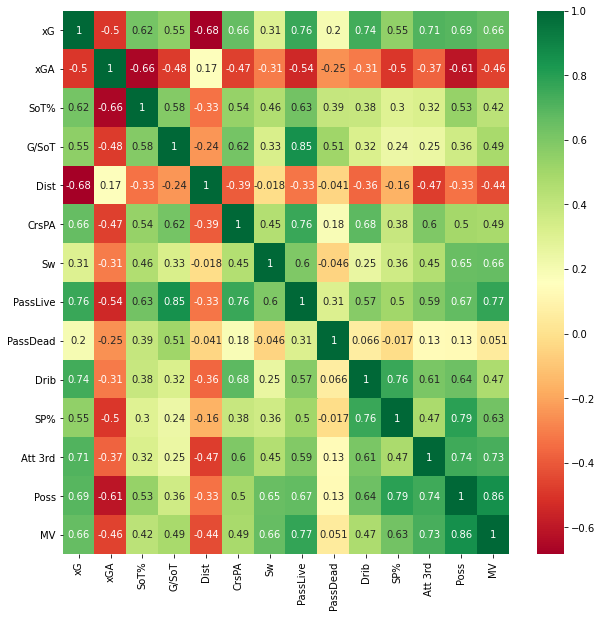

In [42]:
# get correlations of each feature in dataset
dataFeatures = FeatureTable2.drop(['Team'], axis=1)
corrMat = dataFeatures.corr()
plt.figure(figsize=(10, 10))
# plot heat map
k = sns.heatmap(corrMat, annot=True, cmap='RdYlGn')

**Note:** We were able to cut the numbers of features in half, however, since this is a continuing project, new features will be evaluated and maybe included. We still have many medium correlated features, and since we did not include a lot of defensive stats, we might to that as the project goes on. The more independent features, the better (as long as the features are correlated to y).

In [43]:
Feature_Table = FeatureToMatchDayTable(MatchPlan, FeatureTable2)
Feature_Table.head()

,HomeTeam,AwayTeam,FTR,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV
0,Bayern Munich,Schalke 04,H,39.0,23.6,3,38.5,0.43,16.5,65,384,77,5,5,34.4,813,62.7,891.40,15.4,39.9,-3,27.1,0.24,17.7,20,231,15,3,1,30.9,544,45.6,165.80
1,Eint Frankfurt,Arminia,D,30.9,24.9,4,35.3,0.32,16.0,47,209,32,7,4,32.8,712,52.5,186.20,12.8,29.4,0,31.2,0.25,18.7,24,273,18,0,1,30.4,531,44.3,45.15
2,Koln,Hoffenheim,A,18.1,31.2,-2,30.7,0.26,16.2,37,234,12,2,1,29.6,533,42.3,101.81,29.2,31.8,0,39.2,0.27,16.9,45,291,29,2,5,33.8,606,50.2,238.33
3,Stuttgart,Freiburg,A,37.1,27.6,0,34.0,0.30,17.2,48,227,34,3,6,33.1,669,51.5,103.45,28.3,27.9,2,38.7,0.33,16.2,45,269,31,5,2,26.3,632,44.8,111.70
4,Union Berlin,Augsburg,A,26.0,19.0,0,39.3,0.38,17.4,45,225,43,5,2,31.8,423,43.4,60.60,17.4,29.4,-1,32.3,0.33,18.0,31,223,20,2,0,29.9,486,43.1,104.28


In [44]:
Feature_Table["FTR"] = Feature_Table.apply(lambda row: transformResult(row),axis=1)
Feature_Table.head()

,HomeTeam,AwayTeam,FTR,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV
0,Bayern Munich,Schalke 04,1,39.0,23.6,3,38.5,0.43,16.5,65,384,77,5,5,34.4,813,62.7,891.40,15.4,39.9,-3,27.1,0.24,17.7,20,231,15,3,1,30.9,544,45.6,165.80
1,Eint Frankfurt,Arminia,0,30.9,24.9,4,35.3,0.32,16.0,47,209,32,7,4,32.8,712,52.5,186.20,12.8,29.4,0,31.2,0.25,18.7,24,273,18,0,1,30.4,531,44.3,45.15
2,Koln,Hoffenheim,-1,18.1,31.2,-2,30.7,0.26,16.2,37,234,12,2,1,29.6,533,42.3,101.81,29.2,31.8,0,39.2,0.27,16.9,45,291,29,2,5,33.8,606,50.2,238.33
3,Stuttgart,Freiburg,-1,37.1,27.6,0,34.0,0.30,17.2,48,227,34,3,6,33.1,669,51.5,103.45,28.3,27.9,2,38.7,0.33,16.2,45,269,31,5,2,26.3,632,44.8,111.70
4,Union Berlin,Augsburg,-1,26.0,19.0,0,39.3,0.38,17.4,45,225,43,5,2,31.8,423,43.4,60.60,17.4,29.4,-1,32.3,0.33,18.0,31,223,20,2,0,29.9,486,43.1,104.28


##### Update: with those features the model performance went up to 44.4% (for a Logistic Regression Model), which is an increase in 6%. We still need a lot more relevant features to get up to a goal of 60%. The follwing section will be witnesses to the investigation of new features. 
Also, when only using the features xG and xGA as features for each team, the model performance is at 33.3%

# Further Feature Investigation
This "Test Section" is about the implementation and evaluation of new features. As mentioned too less defensive stats are included, like SoT conceded etc. We will implement those to see how far we can further improve the model.

# Update: Including Home-Away Split
After some research and former successful observations, splitting each teams performance into away and home stats might increase the accuracy of the model. The data can be fetched from the **FBREF** website once more.

In [45]:
HomeAwayStats = pd.read_csv('HomeAwayStats.csv')
HomeAwayStats = HomeAwayStats.rename(columns={'Squad': 'Team'})
HomeAwayStats.head()

,Rk,Team,MP,W,D,L,GF,GA,GDiff,Pts,Pts/G,HxG,HxGA,xGDiff,xGDiff/90,MP.1,W.1,D.1,L.1,GF.1,GA.1,GDiff.1,Pts.1,Pts/G.1,AxG,AxGA,xGDiff.1,xGDiff/90.1
0,1,Bayern Munich,9,7,2,0,34,12,22,23,2.56,23.0,8.6,14.4,1.79,10,7,1,2,23,14,9,22,2.20,16.0,15.0,1.0,0.10
1,2,RB Leipzig,10,8,1,1,19,6,13,25,2.50,21.7,8.4,13.2,1.32,9,3,4,2,13,11,2,13,1.44,12.7,8.9,3.8,0.42
2,3,Wolfsburg,9,6,3,0,17,8,9,21,2.33,13.9,10.3,3.5,0.44,10,3,5,2,13,11,2,14,1.40,12.7,12.5,0.1,0.01
3,4,Eint Frankfurt,9,4,5,0,17,11,6,17,1.89,15.7,7.5,8.1,0.90,10,4,4,2,21,17,4,16,1.60,17.6,17.8,-0.3,-0.03
4,5,Leverkusen,9,4,3,2,16,11,5,15,1.67,12.1,10.7,1.5,0.16,10,5,2,3,16,8,8,17,1.70,11.9,9.5,2.5,0.25


In [46]:
FeaturesHome = HomeAwayStats[['Team', 'HxG', 'HxGA']] 
FeaturesHome = FeaturesHome.sort_values('Team', ascending=True, ignore_index=True)

FeaturesAway = HomeAwayStats[['Team', 'AxG', 'AxGA']] # variables ending in 2 stand for away stats
FeaturesAway = FeaturesAway.sort_values('Team', ascending=True, ignore_index=True)
FeaturesAway.head()

,Team,AxG,AxGA
0,Arminia,5.6,12.5
1,Augsburg,6.8,13.0
2,Bayern Munich,16.0,15.0
3,Dortmund,21.5,10.3
4,Eint Frankfurt,17.6,17.8


##### Note: Only with splitting xG and xGA into home and away statistics we improved the model from 33.3% to 38.9%. 
This means, we will continue on this path, and try to find further features we can split into home and away stats. 
From the features above, we can still use the "Form" and "MV" statistics, since a home-away split is not needed. Unfortunately, the other statistics are not available in splitted form, so we have to fetch it from other websites.

In [47]:
# Data already downloaded earlier in this document (from football-data.co.uk)
StatsHome = pd.DataFrame(columns=('HST', 'HSTC', 'HS', 'HSC', 'HC', 'HCC', 'HMV', 'Form'))  #'HGS', 'HGC',

TeamHome = MatchFeatures.groupby('HomeTeam') 
#StatsHome.HGS = TeamHome.FTHG.mean().values
#StatsHome.HGC = TeamHome.FTAG.mean().values
StatsHome.HST = TeamHome.HST.mean().values
StatsHome.HSTC = TeamHome.AST.mean().values
StatsHome['HS'] = TeamHome.HS.mean().values
StatsHome['HSC'] = TeamHome.AS.mean().values
StatsHome.HC = TeamHome.HC.mean().values
StatsHome.HCC = TeamHome.AC.mean().values
#StatsHome['HST%'] = TeamHome.HST.mean().values / StatsHome.HS *100 
#StatsHome['HSTC%'] = TeamHome.AST.mean().values / StatsHome.HSC *100
StatsHome.HMV = PossessionStats['MV']                                      #Market value
StatsHome.Form = FeatureTable['Form']

frames = [FeaturesHome, StatsHome]                           #.drop(['HxG', 'HxGA'], axis=1)
JoinedHomeStats = pd.concat(frames, axis=1)
JoinedHomeStats = JoinedHomeStats.round(2)
JoinedHomeStats.head()

,Team,HxG,HxGA,HST,HSTC,HS,HSC,HC,HCC,HMV,Form
0,Arminia,7.2,17.0,2.70,5.70,8.30,14.00,2.60,7.60,45.15,0
1,Augsburg,11.1,18.2,3.30,5.80,10.00,14.40,3.30,5.50,104.28,-1
2,Bayern Munich,23.0,8.6,8.00,4.22,17.89,10.22,9.22,2.89,891.40,3
3,Dortmund,18.0,10.9,5.56,4.00,14.22,10.33,5.56,2.44,615.20,0
4,Eint Frankfurt,15.7,7.5,5.33,3.44,13.67,10.44,5.89,5.00,186.20,4


In [48]:
# Same for Away Team stats
StatsAway = pd.DataFrame(columns=('AST', 'ASTC', 'AS', 'ASC', 'AC', 'ACC', 'AMV', 'Form')) #'AGS', 'AGC',

TeamAway = MatchFeatures.groupby('AwayTeam')  
#StatsAway.AGS = TeamAway.FTAG.mean().values
#StatsAway.AGC = TeamAway.FTHG.mean().values
StatsAway.AST = TeamAway.AST.mean().values
StatsAway.ASTC = TeamAway.HST.mean().values
StatsAway.AS = TeamAway.AS.mean().values
StatsAway.ASC = TeamAway.HS.mean().values
StatsAway.AC = TeamAway.AC.mean().values
StatsAway.ACC = TeamAway.HC.mean().values
#StatsAway['AST%'] = TeamAway.AST.mean().values / StatsAway.AS *100     #Might include later
#StatsAway['ASTC%'] = TeamAway.HST.mean().values / StatsAway.ASC *100
StatsAway.AMV = PossessionStats['MV']                                 #Market value
StatsAway.Form = FeatureTable['Form']

frames = [FeaturesAway, StatsAway]      # .drop(['AxG', 'AxGA'], axis=1)
JoinedAwayStats = pd.concat(frames, axis=1)
JoinedAwayStats = JoinedAwayStats.round(2)
JoinedAwayStats.head()

,Team,AxG,AxGA,AST,ASTC,AS,ASC,AC,ACC,AMV,Form
0,Arminia,5.6,12.5,2.56,5.67,8.89,12.78,3.67,5.00,45.15,0
1,Augsburg,6.8,13.0,2.89,4.78,8.67,13.11,2.33,5.78,104.28,-1
2,Bayern Munich,16.0,15.0,6.10,4.10,16.00,11.90,5.80,4.20,891.40,3
3,Dortmund,21.5,10.3,6.50,4.50,16.00,10.10,6.20,4.10,615.20,0
4,Eint Frankfurt,17.6,17.8,5.10,5.30,13.10,13.00,5.10,4.70,186.20,4


##### Note: It was tried to just take the difference (of AST and ASTC for example), bis this lead into a decrease of the model performance of over 10%). So, we will keep the individual statistics.

##### Note: including ST, STC, S, SC for Home and Away Team could further increase the models accuracy by about 6%. Including Market value also increased the model performance, including the form lead to no performance increase nor decrease.

Now we need to create a function that attaches the home or away stats to the matchday games

In [49]:
def HomeAwayToMatchDay(matchday, homestats, awaystats):
    ''' Function to attach appropriate statistics to teams of matchday'''
    # Loop through "HomeTeam" column and attach row from the FeatureTable according to the team
    df_home = pd.DataFrame()

    for team in range(len(matchday.HomeTeam)):
        for team2 in range(len(homestats.Team)):
            if (matchday.HomeTeam[team] == homestats.Team[team2]):
                df_home = df_home.append(homestats.iloc[[team2]], ignore_index=True)
    
    # Append Hometeam stats to matchdays
    frames = [matchday, df_home.drop(['Team'], axis=1)]
    df = pd.concat(frames, axis=1)
    
    # same for away team stats
    df_away = pd.DataFrame()

    for team in range(len(matchday.AwayTeam)):
        for team2 in range(len(awaystats.Team)):
            if (matchday.AwayTeam[team] == awaystats.Team[team2]):
                df_away = df_away.append(awaystats.iloc[[team2]], ignore_index=True)
    
    # Attach Awayteam stats to matchdays to finish up the FeatureTable
    frames = [df, df_away.drop(['Team'], axis=1)]
    joinedtables = pd.concat(frames, axis=1)
    return joinedtables

In [50]:
HomeAwayFeatureTable = HomeAwayToMatchDay(MatchPlan, JoinedHomeStats, JoinedAwayStats)

In [51]:
HomeAwayFeatureTable["FTR"] = HomeAwayFeatureTable.apply(lambda row: transformResult(row),axis=1)
HomeAwayFeatureTable.head()

,HomeTeam,AwayTeam,FTR,HxG,HxGA,HST,HSTC,HS,HSC,HC,HCC,HMV,Form,AxG,AxGA,AST,ASTC,AS,ASC,AC,ACC,AMV,Form
0,Bayern Munich,Schalke 04,1,23.0,8.6,8.00,4.22,17.89,10.22,9.22,2.89,891.40,3,6.2,21.0,1.89,8.11,9.22,17.33,3.22,6.44,165.80,-3
1,Eint Frankfurt,Arminia,0,15.7,7.5,5.33,3.44,13.67,10.44,5.89,5.00,186.20,4,5.6,12.5,2.56,5.67,8.89,12.78,3.67,5.00,45.15,0
2,Koln,Hoffenheim,-1,7.7,15.3,3.50,5.30,9.60,12.70,3.80,5.50,101.81,-2,14.8,15.8,5.20,5.50,13.40,12.60,4.70,4.80,238.33,0
3,Stuttgart,Freiburg,-1,14.4,15.0,4.33,5.89,13.78,13.33,4.78,5.00,103.45,0,8.9,14.1,3.78,5.89,8.22,16.11,3.33,5.56,111.70,2
4,Union Berlin,Augsburg,-1,14.9,10.5,5.40,3.70,13.30,10.50,4.60,3.90,60.60,0,6.8,13.0,2.89,4.78,8.67,13.11,2.33,5.78,104.28,-1


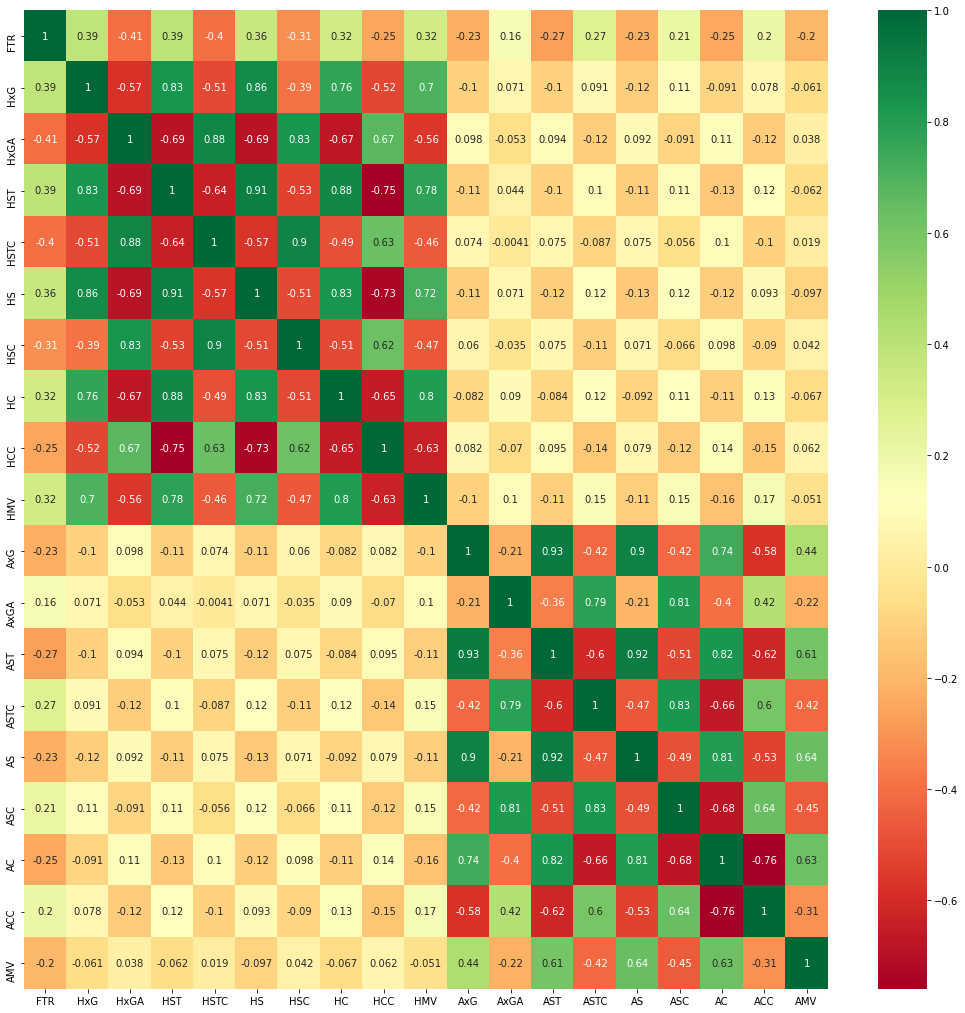

In [52]:
# get correlations of each feature in dataset
dataFeatures3 = HomeAwayFeatureTable.drop(['HomeTeam', 'AwayTeam', 'FTR'], axis=1)
corrMat = HomeAwayFeatureTable.corr()
plt.figure(figsize=(18, 18))
# plot heat map
m = sns.heatmap(corrMat, annot=True, cmap='RdYlGn')

##### Note: Since xG and ST have such a high correlation, I tried to drop xG, which did not lead to any performance loss. In fact, the performance stayed exactly the same. But since xG seems to be an important feature, it will stay in the dataset

# Odds-implied Probability
The paper from Edward Wheatcroft, *Forecasting football matches by predicting match statistics*, stated that taking the inverse of the maximum betting odd can increase the proficiency of the betting strategy. In this section we will include the odds-implied probability for each match and observe the model performance. With that being said, **the highest odds for the hometeam will be taken into account**. A variety of odda are already included in the *football-stats.co.uk" Dataset

In [53]:
#Odds = MatchFeatures[['HomeTeam', 'AwayTeam', 'B365H', 'BWH', 'IWH', 'PSH', 'WHH', 'VCH', 'MaxH']]
#Odds.head()

In [54]:
## Choosing the highest odds from the bookmaker offers above (highest value in each row)
#OddsPlain = Odds.drop(['HomeTeam', 'AwayTeam'], axis=1)
#maxOdd = OddsPlain.max(axis = 1) 
#OddsImplied = 1 / maxOdd           # Taking the inverse
#OddsImplied.head()

In [55]:
## Include Odds-Implied Probability to feature table
#HomeAwayFeatureTable.insert(3, 'OddH', OddsImplied)
#HomeAwayFeatureTable.head()

##### Observation: Including the Odds-implied did not change the model performance

# Train-Test-Split

In [56]:
# Setting up X and y Data
X = HomeAwayFeatureTable.drop(['HomeTeam', 'AwayTeam', 'FTR'], axis=1) # Dropping Team names and FTR
y = HomeAwayFeatureTable['FTR']

In [57]:
X.head()

,HxG,HxGA,HST,HSTC,HS,HSC,HC,HCC,HMV,Form,AxG,AxGA,AST,ASTC,AS,ASC,AC,ACC,AMV,Form
0,23.0,8.6,8.00,4.22,17.89,10.22,9.22,2.89,891.40,3,6.2,21.0,1.89,8.11,9.22,17.33,3.22,6.44,165.80,-3
1,15.7,7.5,5.33,3.44,13.67,10.44,5.89,5.00,186.20,4,5.6,12.5,2.56,5.67,8.89,12.78,3.67,5.00,45.15,0
2,7.7,15.3,3.50,5.30,9.60,12.70,3.80,5.50,101.81,-2,14.8,15.8,5.20,5.50,13.40,12.60,4.70,4.80,238.33,0
3,14.4,15.0,4.33,5.89,13.78,13.33,4.78,5.00,103.45,0,8.9,14.1,3.78,5.89,8.22,16.11,3.33,5.56,111.70,2
4,14.9,10.5,5.40,3.70,13.30,10.50,4.60,3.90,60.60,0,6.8,13.0,2.89,4.78,8.67,13.11,2.33,5.78,104.28,-1


In [58]:
X_test = X.iloc[-18:, :] #Last 2 Matchdays (18 games) as test data
y_test = y.iloc[-18:]

X_train = X.iloc[:-18, :] # Rest of Dataset as training data
y_train = y.iloc[:-18]

## Scaling the Data

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training Models
## Linear Regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [61]:
reg_clf = LogisticRegression(random_state=42)
reg_clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [62]:
y_pred = reg_clf.predict(X_test)
y_pred

array([ 1, -1, -1,  0,  1, -1, -1, -1,  1,  0,  1,  1,  0,  0,  1,  1, -1,
        1])

In [83]:
pred_proba2 = reg_clf.predict_proba(X_test)
pred_proba2 #Probabilities for each outcome

array([[0.15073982, 0.30139188, 0.5478683 ],
       [0.77332276, 0.169016  , 0.05766124],
       [0.42870638, 0.33657583, 0.23471779],
       [0.20696224, 0.53295668, 0.26008108],
       [0.21158128, 0.37118796, 0.41723075],
       [0.8801082 , 0.10885624, 0.01103556],
       [0.4206209 , 0.36976428, 0.20961482],
       [0.90133365, 0.0587936 , 0.03987275],
       [0.20447163, 0.25394172, 0.54158665],
       [0.31263577, 0.38919533, 0.29816891],
       [0.02252842, 0.19629274, 0.78117884],
       [0.36502706, 0.24831975, 0.38665319],
       [0.01317536, 0.61047312, 0.37635152],
       [0.21563294, 0.48823664, 0.29613041],
       [0.03448738, 0.21308953, 0.7524231 ],
       [0.1348425 , 0.15922096, 0.70593654],
       [0.43259201, 0.28679334, 0.28061465],
       [0.07071671, 0.40891677, 0.52036651]])

In [63]:
f1_score(y_test, y_pred, average='micro')

0.5555555555555556

In [64]:
confusion_matrix(y_pred, y_test)

array([[3, 0, 3],
       [0, 1, 3],
       [1, 1, 6]])

In [65]:
result = Feature_Table.iloc[-18:, 0:3]
result['Pred'] = y_pred
result

,HomeTeam,AwayTeam,FTR,Pred
153,M'Gladbach,Dortmund,1,1
154,Augsburg,Union Berlin,1,-1
155,Arminia,Eint Frankfurt,-1,-1
156,Freiburg,Stuttgart,1,0
157,Leverkusen,Wolfsburg,-1,1
158,Mainz 05,RB Leipzig,1,-1
159,Hertha BSC,Werder Bremen,-1,-1
160,Schalke 04,Bayern Munich,-1,-1
161,Hoffenheim,Koln,1,1
162,Stuttgart,Mainz 05,1,0


## XGBoost

In [66]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_clf = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_clf.fit(X_train, y_train)

/Users/david/ml/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:39:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
y2_pred = xgb_clf.predict(X_test)
y2_pred

array([ 1, -1,  1,  0,  0, -1,  0, -1, -1, -1,  1,  1,  0,  0,  1,  1, -1,
        1])

In [68]:
f1_score(y_test, y2_pred, average='micro') # XGBoost all games

0.3888888888888889

It seems that the Logistic Regression model outperformes thr XGBoost model

## Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier

ran_clf = RandomForestClassifier(n_estimators = 10, criterion='entropy', random_state=42)
ran_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [70]:
y3_pred = ran_clf.predict(X_test)
y3_pred

array([ 1, -1, -1,  0,  0, -1, -1, -1,  0, -1,  1,  1,  1,  0,  1,  0, -1,
        1])

In [71]:
f1_score(y_test, y3_pred, average='micro') 

0.5

In [72]:
result = HomeAwayFeatureTable.iloc[-18:, 0:3]
result['Log_Reg'] = y_pred
result['XGBoost'] = y2_pred
result['Ran_For'] = y3_pred
result

,HomeTeam,AwayTeam,FTR,Log_Reg,XGBoost,Ran_For
153,M'Gladbach,Dortmund,1,1,1,1
154,Augsburg,Union Berlin,1,-1,-1,-1
155,Arminia,Eint Frankfurt,-1,-1,1,-1
156,Freiburg,Stuttgart,1,0,0,0
157,Leverkusen,Wolfsburg,-1,1,0,0
158,Mainz 05,RB Leipzig,1,-1,-1,-1
159,Hertha BSC,Werder Bremen,-1,-1,0,-1
160,Schalke 04,Bayern Munich,-1,-1,-1,-1
161,Hoffenheim,Koln,1,1,-1,0
162,Stuttgart,Mainz 05,1,0,-1,-1


# Betting Scheme
The probability of each outcome will be displayed and compared to the betting odds. If potential profit at any given bet becomes obvious, the bet will be displayed.

In [127]:
matchPred = pd.read_csv('MatchPred.csv')
matchPred

,HomeTeam,AwayTeam
0,Hertha BSC,Bayern Munich
1,Mainz 05,Union Berlin
2,Freiburg,Dortmund
3,Schalke 04,RB Leipzig
4,Augsburg,Wolfsburg
5,Leverkusen,Stuttgart
6,M'Gladbach,Koln
7,Hoffenheim,Eint Frankfurt
8,Arminia,Werder Bremen


In [128]:
TeamStats = HomeAwayToMatchDay(matchPred, JoinedHomeStats, JoinedAwayStats)
TeamStats

,HomeTeam,AwayTeam,HxG,HxGA,HST,HSTC,HS,HSC,HC,HCC,HMV,Form,AxG,AxGA,AST,ASTC,AS,ASC,AC,ACC,AMV,Form
0,Hertha BSC,Bayern Munich,11.7,11.2,5.22,3.67,13.89,8.89,6.11,3.33,251.93,-2,16.0,15.0,6.10,4.10,16.00,11.90,5.80,4.20,891.40,3
1,Mainz 05,Union Berlin,13.1,15.4,3.00,5.80,10.50,13.30,4.20,6.10,89.55,-2,11.6,9.4,3.67,4.67,9.78,10.89,4.00,4.89,60.60,0
2,Freiburg,Dortmund,19.4,13.8,5.90,4.60,15.40,13.70,5.10,4.00,111.70,2,21.5,10.3,6.50,4.50,16.00,10.10,6.20,4.10,615.20,0
3,Schalke 04,RB Leipzig,9.1,18.8,4.40,6.80,12.20,17.30,4.00,5.40,165.80,-3,12.7,8.9,4.89,3.22,11.78,8.33,5.22,4.78,552.68,0
4,Augsburg,Wolfsburg,11.1,18.2,3.30,5.80,10.00,14.40,3.30,5.50,104.28,-1,12.7,12.5,4.80,4.20,13.40,12.90,4.50,6.10,218.55,1
5,Leverkusen,Stuttgart,12.1,10.7,5.44,3.22,13.44,9.44,5.00,3.00,343.45,-2,22.6,12.6,6.60,4.00,16.40,12.00,5.50,3.80,103.45,0
6,M'Gladbach,Koln,15.8,10.5,5.20,3.80,12.70,13.20,5.00,4.30,343.13,4,10.4,15.8,3.22,4.78,9.33,13.00,4.67,4.33,101.81,-2
7,Hoffenheim,Eint Frankfurt,14.5,16.0,5.44,4.22,11.33,11.44,4.56,4.89,238.33,0,17.6,17.8,5.10,5.30,13.10,13.00,5.10,4.70,186.20,4
8,Arminia,Werder Bremen,7.2,17.0,2.70,5.70,8.30,14.00,2.60,7.60,45.15,0,11.6,14.0,4.10,4.90,9.50,14.20,3.60,4.40,107.20,0


In [129]:
X_pred = TeamStats.drop(['HomeTeam', 'AwayTeam'], axis=1) # Dropping Team names and FTR
X_pred

,HxG,HxGA,HST,HSTC,HS,HSC,HC,HCC,HMV,Form,AxG,AxGA,AST,ASTC,AS,ASC,AC,ACC,AMV,Form
0,11.7,11.2,5.22,3.67,13.89,8.89,6.11,3.33,251.93,-2,16.0,15.0,6.10,4.10,16.00,11.90,5.80,4.20,891.40,3
1,13.1,15.4,3.00,5.80,10.50,13.30,4.20,6.10,89.55,-2,11.6,9.4,3.67,4.67,9.78,10.89,4.00,4.89,60.60,0
2,19.4,13.8,5.90,4.60,15.40,13.70,5.10,4.00,111.70,2,21.5,10.3,6.50,4.50,16.00,10.10,6.20,4.10,615.20,0
3,9.1,18.8,4.40,6.80,12.20,17.30,4.00,5.40,165.80,-3,12.7,8.9,4.89,3.22,11.78,8.33,5.22,4.78,552.68,0
4,11.1,18.2,3.30,5.80,10.00,14.40,3.30,5.50,104.28,-1,12.7,12.5,4.80,4.20,13.40,12.90,4.50,6.10,218.55,1
5,12.1,10.7,5.44,3.22,13.44,9.44,5.00,3.00,343.45,-2,22.6,12.6,6.60,4.00,16.40,12.00,5.50,3.80,103.45,0
6,15.8,10.5,5.20,3.80,12.70,13.20,5.00,4.30,343.13,4,10.4,15.8,3.22,4.78,9.33,13.00,4.67,4.33,101.81,-2
7,14.5,16.0,5.44,4.22,11.33,11.44,4.56,4.89,238.33,0,17.6,17.8,5.10,5.30,13.10,13.00,5.10,4.70,186.20,4
8,7.2,17.0,2.70,5.70,8.30,14.00,2.60,7.60,45.15,0,11.6,14.0,4.10,4.90,9.50,14.20,3.60,4.40,107.20,0


In [130]:
# scalar object already implemented previously (StandardScaler)
# Include whole Dataset now
X_scaled = scaler.fit_transform(X)
X_pred = scaler.transform(X_pred) # Neglect this step and all predictions will be 0, important to include

In [131]:
#using full Dataset now (X) to train the model
# logistic Regression Model already implemented
reg_clf2 = LogisticRegression(random_state=42)
reg_clf2.fit(X_scaled, y)

LogisticRegression(random_state=42)

In [132]:
#Predict match outcomes
pred = reg_clf2.predict(X_pred)
pred

array([-1, -1,  1, -1, -1, -1,  1, -1, -1])

In [133]:
pred_proba = reg_clf2.predict_proba(X_pred)
pred_proba = pred_proba*100 #Probabilities for each outcome
pred_proba = pred_proba.round(2) #round numbers
pred_proba

array([[73.94, 15.11, 10.95],
       [57.46, 26.51, 16.02],
       [22.22, 36.9 , 40.88],
       [85.68, 10.58,  3.74],
       [63.72, 22.56, 13.72],
       [48.04, 17.35, 34.62],
       [ 3.45, 40.68, 55.87],
       [33.95, 32.23, 33.82],
       [55.05, 15.  , 29.95]])

In [134]:
pred_proba = pd.DataFrame(data=pred_proba, columns=['AW%', 'D%', 'HW%']) #to pandas dataframe
predict = pred_proba[['HW%', 'D%', 'AW%']]  #Switching Homewin and Awaywin for better visibility
result = pd.concat([matchPred, predict], axis=1)
result

,HomeTeam,AwayTeam,HW%,D%,AW%
0,Hertha BSC,Bayern Munich,10.95,15.11,73.94
1,Mainz 05,Union Berlin,16.02,26.51,57.46
2,Freiburg,Dortmund,40.88,36.90,22.22
3,Schalke 04,RB Leipzig,3.74,10.58,85.68
4,Augsburg,Wolfsburg,13.72,22.56,63.72
5,Leverkusen,Stuttgart,34.62,17.35,48.04
6,M'Gladbach,Koln,55.87,40.68,3.45
7,Hoffenheim,Eint Frankfurt,33.82,32.23,33.95
8,Arminia,Werder Bremen,29.95,15.00,55.05


## Web Scraping best Odds
The next step is to compare our probabilities with the average odds from a couple bookies and sort out the bets with potential profit (If our model predicts a 10% difference than the odds). We will make this an automatic process, since it would be time-consuming looking for the best odds and create a .csv file

In [177]:
df = pd.read_html('https://www.wettportal.com/Fussball/Deutschland/Bundesliga/')

In [185]:
table = pd.DataFrame(df[0])
table.head()

,Datum,Spiel,Unnamed: 2,1,x,2,Unnamed: 6
0,07.02. 15:30,TSG Hoffenheim - Eintracht Frankfurt,NaN,3.00,4.09,2.39,Vergleiche 8 Buchmacher
1,07.02. 18:00,Arminia Bielefeld - Werder Bremen,NaN,3.28,3.28,2.45,Vergleiche 8 Buchmacher
2,12.02. 20:30,RB Leipzig - FC Augsburg,NaN,1.29,6.35,12.50,Vergleiche 8 Buchmacher
3,13.02. 15:30,Bayer Leverkusen - FSV Mainz 05,NaN,1.43,5.35,7.70,Vergleiche 8 Buchmacher
4,13.02. 15:30,Borussia Dortmund - TSG Hoffenheim,NaN,1.55,4.82,6.85,Vergleiche 8 Buchmacher
5,13.02. 15:30,VfB Stuttgart - Hertha BSC,NaN,2.10,3.98,3.54,Vergleiche 8 Buchmacher
6,13.02. 15:30,Werder Bremen - SC Freiburg,NaN,2.80,3.58,2.70,Vergleiche 8 Buchmacher
7,13.02. 18:30,1. FC Union Berlin - FC Schalke 04,NaN,1.89,3.82,4.60,Vergleiche 8 Buchmacher
8,14.02. 15:30,Eintracht Frankfurt - 1. FC Köln,NaN,1.58,4.55,6.30,Vergleiche 8 Buchmacher
9,14.02. 18:00,VfL Wolfsburg - Borussia Mönchengladbach,NaN,2.59,3.85,2.81,Vergleiche 8 Buchmacher


In [199]:
MatchOdds = table[['Spiel', '1', 'x', '2']]
MatchOdds.head()

,Spiel,1,x,2
0,TSG Hoffenheim - Eintracht Frankfurt,3.00,4.09,2.39
1,Arminia Bielefeld - Werder Bremen,3.28,3.28,2.45
2,RB Leipzig - FC Augsburg,1.29,6.35,12.50
3,Bayer Leverkusen - FSV Mainz 05,1.43,5.35,7.70
4,Borussia Dortmund - TSG Hoffenheim,1.55,4.82,6.85


In [200]:
# Take the inverse of odds to get the percentage
MatchOdds['1'] = 1 / MatchOdds['1'] *100
MatchOdds['x'] = 1 / MatchOdds['x'] *100
MatchOdds['2'] = 1 / MatchOdds['2'] *100
MatchOdds = MatchOdds.round(2)
MatchOdds.head()

,Spiel,1,x,2
0,TSG Hoffenheim - Eintracht Frankfurt,33.33,24.45,41.84
1,Arminia Bielefeld - Werder Bremen,30.49,30.49,40.82
2,RB Leipzig - FC Augsburg,77.52,15.75,8.00
3,Bayer Leverkusen - FSV Mainz 05,69.93,18.69,12.99
4,Borussia Dortmund - TSG Hoffenheim,64.52,20.75,14.60


Now, we will compare the model prediction with the odds. When our model is predicting a specific outcome (HW/D/AW) for higher than **10%** of what the odds say, it will return a potential bet.